In [59]:
%matplotlib inline

import ipyleaflet

import numpy as np

import pandas
from pandas.plotting import scatter_matrix

import random

import pickle

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import randint

In [60]:
listings = pandas.read_csv('listings.csv');
listings.drop(listings[listings['areaM2'] > 150].index, inplace=True)
listings.drop(listings[listings['price'] < 100000].index, inplace=True)
# listings.drop(listings[listings['lng'] < 20.95].index, inplace=True)
# listings.drop(listings[listings['lng'] > 21.09].index, inplace=True)
# listings.drop(listings[listings['lat'] > 52.25].index, inplace=True)
for index, listing in listings.iterrows():
    for index in range(10):
        lat = listing['lat'] + random.uniform(-0.01,0.01)
        lng = listing['lng'] + random.uniform(-0.01,0.01)
        price = listing['price'] + random.randint(-3000,3000)
        listings = listings.append(pandas.Series({
            'price': price,
            'areaM2': listing['areaM2'],
            'lat': lat,
            'lng': lng,
            'nrOfRooms': listing['nrOfRooms'],
            'floorNr': listing['floorNr'],
            'nrOfFloors': listing['nrOfFloors'],
            'yearBuilt': listing['yearBuilt'],
        }), ignore_index=True)
listings["price"] = listings["price"] / listings["areaM2"]
listings.describe()

,price,areaM2,lat,lng,nrOfRooms,floorNr,nrOfFloors,yearBuilt
count,10219.000000,10219.000000,10219.000000,10219.000000,10219.000000,10219.000000,10219.000000,9570.000000
mean,8252.578649,52.403402,52.200877,21.023079,2.325081,3.370291,6.675996,1976.357471
std,1716.995538,19.069798,0.039596,0.039015,0.810245,2.940275,3.841143,21.811657
min,4579.018519,16.500000,52.118550,20.876433,1.000000,0.000000,0.000000,1882.000000
25%,7138.730243,38.400000,52.172442,21.001392,2.000000,1.000000,4.000000,1964.000000
50%,7963.234043,48.200000,52.199158,21.025302,2.000000,3.000000,5.000000,1976.000000
75%,8981.914820,60.000000,52.229856,21.051163,3.000000,4.000000,10.000000,1994.000000
max,19540.152542,150.000000,52.355011,21.173175,6.000000,19.000000,29.000000,2017.000000


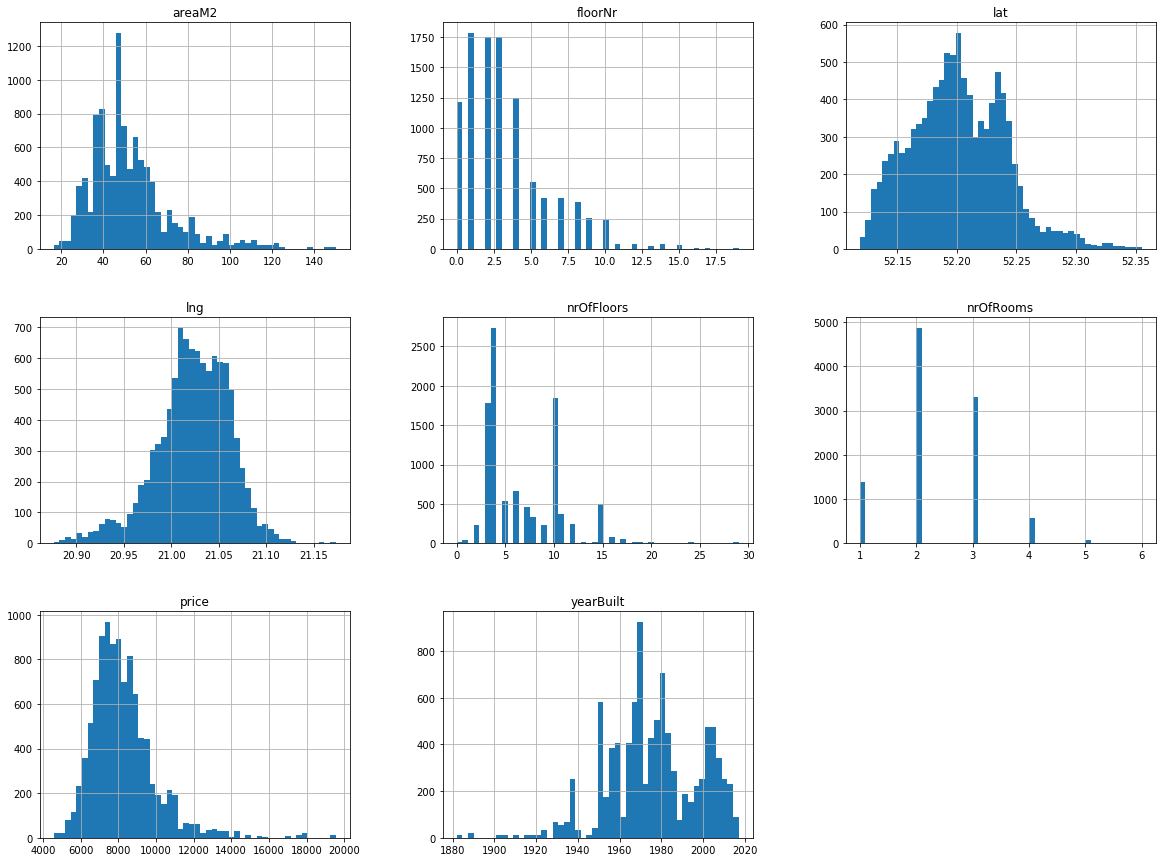

In [61]:
listings.hist(bins=50, figsize=(20,15))
plt.show()

In [62]:
train_set, test_set = train_test_split(listings, test_size=0.2, random_state=42)

print(len(train_set), "train +", len(test_set), "test")
test_set.head()

8175 train + 2044 test


,price,areaM2,lat,lng,nrOfRooms,floorNr,nrOfFloors,yearBuilt
4176,9167.189655,58.0,52.125624,21.046614,2.0,3.0,5.0,2001.0
7825,9450.650407,49.2,52.239553,20.983022,2.0,10.0,29.0,2004.0
590,8743.169399,36.6,52.193075,21.067246,1.0,1.0,3.0,2004.0
33,8692.307692,39.0,52.188321,21.053631,2.0,1.0,4.0,1980.0
5967,8338.120000,25.0,52.193429,20.966016,1.0,0.0,10.0,1969.0


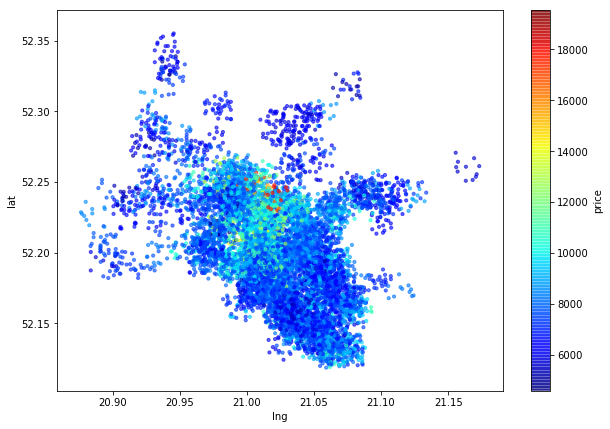

In [63]:
listings.plot(kind="scatter", x="lng", y="lat", alpha=0.6, figsize=(10, 7), s=10, c='price', cmap=plt.get_cmap("jet"), colorbar=True, sharex=False)
# train_set.plot(kind="scatter", x="lng", y="lat", alpha=0.6, figsize=(10, 7), s=100, c='price', cmap=plt.get_cmap("jet"), colorbar=True, sharex=False)
# test_set.plot(kind="scatter", x="lng", y="lat", alpha=0.6, figsize=(10, 7), s=100, c='price', cmap=plt.get_cmap("jet"), colorbar=True, sharex=False)



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f064c254ba8>,
      dtype=object)

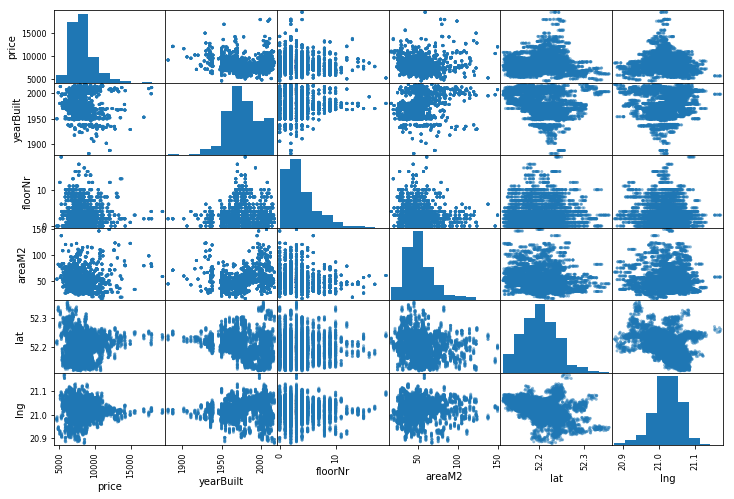

In [64]:
attrs = ['price', 'yearBuilt', 'floorNr', 'areaM2', 'lat', 'lng']

scatter_matrix(listings[attrs], figsize=(12,8))

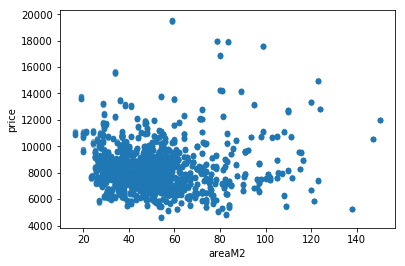

In [65]:
listings.plot(kind="scatter", x="areaM2", y="price", alpha=0.4)
# plt.axis([0, 100, 0, 1000000])

In [66]:
# Create labels and remove labels from train set

labels = train_set["price"].copy()
train_set = train_set.drop("price", axis=1)

In [67]:
labels.head()

538     7931.034483
3608    7154.984127
9462    7905.157895
2109    9600.849057
1400    8078.364023
Name: price, dtype: float64

In [68]:
train_set.head()

,areaM2,lat,lng,nrOfRooms,floorNr,nrOfFloors,yearBuilt
538,43.50,52.152347,21.035866,2.0,1.0,4.0,1980.0
3608,63.00,52.155144,21.012948,3.0,4.0,7.0,NaN
9462,38.00,52.217531,21.025345,2.0,0.0,10.0,NaN
2109,53.00,52.235215,21.025255,2.0,0.0,6.0,1936.0
1400,56.48,52.203457,21.023005,3.0,7.0,10.0,NaN


In [69]:
param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=7),
    }
forest_reg = RandomForestRegressor()

pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
        ('randomized_search_cv_rfr', RandomizedSearchCV(
                forest_reg,
                param_distributions=param_distribs,
                n_iter=10,
                cv=5,
                scoring='neg_mean_squared_error'
            )
        )
    ])

pipeline.fit(train_set, labels)

X_test = test_set.drop("price", axis=1)
Y_test = test_set["price"].copy()

final_predictions = pipeline.predict(X_test)

final_mse = mean_squared_error(Y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

289.0676165850796

In [70]:
test = pandas.DataFrame([{
    'areaM2': 39,
    'lat': 52.287113,
    'lng': 21.0682564,
    'nrOfRooms': 1,
    'floorNr': 1,
    'nrOfFloors': 4,
    'yearBuilt': 1964
}])

In [71]:
test_prediction = pipeline.predict(test)
test_prediction

array([7938.43635189])

In [72]:
pipeline.steps[2][1].best_params_

{'max_features': 1, 'n_estimators': 84}

In [73]:
model_pkl = open('model.pkl', 'wb')
pickle.dump(pipeline, model_pkl)
model_pkl.close()

In [74]:
pipeline = pickle.load(open('model.pkl', 'rb'))